## Imports

In [1]:
import re
import os
import subprocess

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [2]:
def parse_performance_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Initial Score:\s*(?P<Initial_Score>\d+)\s*"
        r"Score:\s*(?P<Score>\d+)\s*"
        r"Number\s*of\s*Evaluations:\s*(?P<Number_of_Evaluations>\d+)\s*"
        r"Number\s*of\s*Performed\s*Moves:\s*(?P<Number_of_Performed_Moves>\d+)\s*"
        r"Number\s*of\s*Best\s*Solution\s*Updates:\s*(?P<Number_of_Best_Solution_Updates>\d+)\s*"
        r"Solution:\s*(?P<Solution>[\d\s]+)\s*"
        r"Optimal\s*Score:\s*(?P<Optimal_Score>\d+)\s*"
        r"Optimal\s*Solution:\s*(?P<Optimal_Solution>[\d\s]+)"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Initial_Score', 'Score', 'Number_of_Evaluations', 'Number_of_Performed_Moves', 'Number_of_Best_Solution_Updates', 'Optimal_Score']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df

def parse_runtime_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Runtime:\s*(?P<Runtime>\S+)\s*"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Runtime']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df


def run_bio_alg(instance_dir, runtime_results_file, performance_results_file, mode, instance_names, random_time=2871222):
    runtime_commands = [
        "bio_alg time heuristic 0 0 {dir} {instance} {result}",
        "bio_alg time random 0 0 {dir} {instance} {result}",
        "bio_alg time antiheuristic 0 0 {dir} {instance} {result}",
        "bio_alg time random 0 0 {dir} {instance} {result} greedyLS",
        "bio_alg time random 0 0 {dir} {instance} {result} steepestLS"
    ]

    performance_commands = [
        "bio_alg performance heuristic 100 0 {dir} {instance} {result}",
        "bio_alg performance antiheuristic 100 0 {dir} {instance} {result}",
        "bio_alg performance randomwalk 100 " + random_time + " {dir} {instance} {result}",
        "bio_alg performance randomsearch 100 " + random_time + " {dir} {instance} {result}",
        "bio_alg performance random 100 0 {dir} {instance} {result} greedyLS",
        "bio_alg performance random 100 0 {dir} {instance} {result} steepestLS"
    ]

    for instance in instance_names:
        assert os.path.exists(os.path.join(instance_dir, instance[:-4] + ".sln")), "Instance should have a corresponding .sln file"

    if os.path.exists(runtime_results_file):    
        os.remove(runtime_results_file)

    if os.path.exists(performance_results_file):    
        os.remove(performance_results_file)

    for instance in instance_names:
        if mode in ("runtime", "both"):
            for cmd in runtime_commands:
                for _ in range(10):  # Make 10 tests for standard deviation
                    formatted_cmd = cmd.format(dir=instance_dir, instance=instance, result=runtime_results_file)
                    subprocess.run(formatted_cmd, shell=True)

        if mode in ("performance", "both"):
            for cmd in performance_commands:
                formatted_cmd = cmd.format(dir=instance_dir, instance=instance, result=performance_results_file)
                subprocess.run(formatted_cmd, shell=True)


## Define variables
### Optional - run scripts from python

In [3]:
performance_file = 'results/performance_results.txt'
runtime_file = 'results/runtime_results.txt'
performance_file_300 = 'results/performance_results_300.txt'

num_restarts = [20, 50, 100, 150, 200, 300, 500]
restarts_files_path = "results/MSLS_tests/"

selected_instances = ["chr22a", "tai60a"]

In [4]:
# Names of instances ordered by instance size
instance_names_ordered = ["wil100", "lipa80a", "tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "chr20c", "had14"][::-1]

RANDOMRUNTIMES = {'bur26a': 3123592.0,
                'bur26b': 2541337.0,
                'chr20c': 647929.9,
                'chr22a': 667595.9,
                'had14': 206135.0,
                'kra30a': 2795186.0,
                'lipa80a': 86358480.0,
                'tai60a': 29373680.0,
                'wil100': 1075083000.0}

algorithm_colors = {
    "greedyLS": "#e41a1c",
    "steepestLS": "#377eb8",
    "heuristic": "#4daf4a",
    "antiheuristic": "#a65628",
    "random": "#ff7f00",
    "randomwalk": "#fdb462",
    "randomsearch": "#984ea3",
    "iterativeImprovement": "#999999"
}

In [5]:
# run_bio_alg("data/qap/", "runtime_results.txt", "performance_results.txt", "both", instance_names_ordered, RANDOMRUNTIME)

## Read Data

In [6]:
with open(runtime_file, 'r') as file:
    data = file.read()

df_runtime = parse_runtime_data(data)

In [7]:
df_runtime.head()

,Algorithm,Instance,Runtime
0,heuristic,wil100,75123.0
1,heuristic,wil100,61964.0
2,heuristic,wil100,49703.0
3,heuristic,wil100,74242.0
4,heuristic,wil100,42885.0


In [8]:
# RANDOMRUNTIMES = {}
# for i, row in df_runtime[df_runtime.Algorithm == "greedyLS"].groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index().iterrows():
#     RANDOMRUNTIMES[row.Instance] = row[2]
# RANDOMRUNTIMES

In [9]:
with open(performance_file, 'r') as file:
    data = file.read()

df_performance = parse_performance_data(data)
df_performance.Algorithm = df_performance.Algorithm.apply(lambda x: x[1:] if (x.endswith("LS") or x.endswith("Improvement")) else x)

In [10]:
df_performance.tail()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution
6295,randomsearch,had14,0,2902,196,196,1,7 0 4 2 5 1 11 10 6 9 13 12 3 8 \t,2724,8 13 10 5 12 11 2 14 3 6 7 1 9 4 \n
6296,randomsearch,had14,0,2944,207,207,4,0 6 5 3 4 10 13 11 8 7 2 9 12 1 \t,2724,8 13 10 5 12 11 2 14 3 6 7 1 9 4 \n
6297,randomsearch,had14,0,2960,161,161,3,6 10 11 1 5 12 2 13 9 4 8 0 7 3 \t,2724,8 13 10 5 12 11 2 14 3 6 7 1 9 4 \n
6298,randomsearch,had14,0,2942,225,225,6,3 5 0 13 10 11 9 12 8 6 1 2 4 7 \t,2724,8 13 10 5 12 11 2 14 3 6 7 1 9 4 \n
6299,randomsearch,had14,0,2988,225,225,5,13 2 5 9 12 1 11 4 8 6 10 0 3 7 \t,2724,8 13 10 5 12 11 2 14 3 6 7 1 9 4 \n


# Analysis

### Problem Description
#### 8 Selected instances:

Selected with the intent of checking various sized instances with some repetitions of instance class to verify consistency
***"wil100", "lipa80a", "lipa80b", "tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "had14"***

#### Neighborhood used: pair swap
#### Neighborhood size: n(n-1)/2 

## Runtime

In [11]:
def plot_algorithms(summary, title="Measure", log_scale=False):
    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Plot each algorithm separately
    algorithms = summary["Algorithm"].unique()
    colors = sns.color_palette("tab10", len(algorithms))

    for i, algorithm in enumerate(algorithms):
        subset = summary[summary["Algorithm"] == algorithm]
        plt.plot(subset["Instance"], subset["mean"], label=f"{algorithm} (Mean)", color=algorithm_colors[algorithm], marker="o", linestyle="-")
        plt.fill_between(subset["Instance"], subset["mean"] - subset["std"], subset["mean"] + subset["std"], alpha=0.2, color=algorithm_colors[algorithm])

    # Labels and legend
    plt.xlabel("Instance")
    plt.ylabel(title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    
    full_title = f"Algorithm {title} per Instance with Standard Deviation"
    
    if log_scale:
        full_title += " (Log scale)"

    plt.title(full_title)
    plt.legend()
    plt.xticks(rotation=45)  # Rotate instance labels for better readability
    plt.show()


def plot_std_line(summary, title="Standard Deviation", overlap=False, log_scale=False):
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    algorithms = summary["Algorithm"].unique()
    instances = summary["Instance"].unique()
    colors = sns.color_palette("tab10", len(algorithms))
    
    bar_width = 0.8 / len(algorithms) if not overlap else 0.8  # Adjust bar width
    
    for i, algorithm in enumerate(algorithms):
        subset = summary[summary["Algorithm"] == algorithm]
        # x_positions = np.arange(len(instances))
        
        # if not overlap:
        #     x_positions = x_positions + i * bar_width - (len(algorithms) - 1) * bar_width / 2
        
        # plt.bar(x_positions, subset["std"], width=bar_width, label=algorithm, color=algorithm_colors[algorithm], alpha=0.7 if overlap else 1)
    
        plt.plot(subset["Instance"], subset["std"], label=f"{algorithm} (std)", color=algorithm_colors[algorithm], marker="o", linestyle="-")

    plt.xlabel("Instance")
    plt.ylabel(title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    
    full_title = f"Algorithm {title} per Instance"
    
    if log_scale:
        full_title += " (Log scale)"

    plt.title(full_title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.xticks(np.arange(len(instances)), instances, rotation=45)
    plt.legend()
    plt.show()

def plot_std_bar(summary, title="Standard Deviation", overlap=False, log_scale=False):
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    algorithms = summary["Algorithm"].unique()
    instances = summary["Instance"].unique()
    colors = sns.color_palette("tab10", len(algorithms))
    
    bar_width = 0.8 / len(algorithms) if not overlap else 0.8  # Adjust bar width
    
    for i, algorithm in enumerate(algorithms):
        subset = summary[summary["Algorithm"] == algorithm]
        x_positions = np.arange(len(instances))
        
        if not overlap:
            x_positions = x_positions + i * bar_width - (len(algorithms) - 1) * bar_width / 2
        
        plt.bar(x_positions, subset["std"], width=bar_width, label=algorithm, color=algorithm_colors[algorithm], alpha=0.7 if overlap else 1)
    
    plt.xlabel("Instance")
    plt.ylabel(title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    
    full_title = f"Algorithm {title} per Instance"
    
    if log_scale:
        full_title += " (Log scale)"

    plt.title(full_title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.xticks(np.arange(len(instances)), instances, rotation=45)
    plt.legend()
    plt.show()


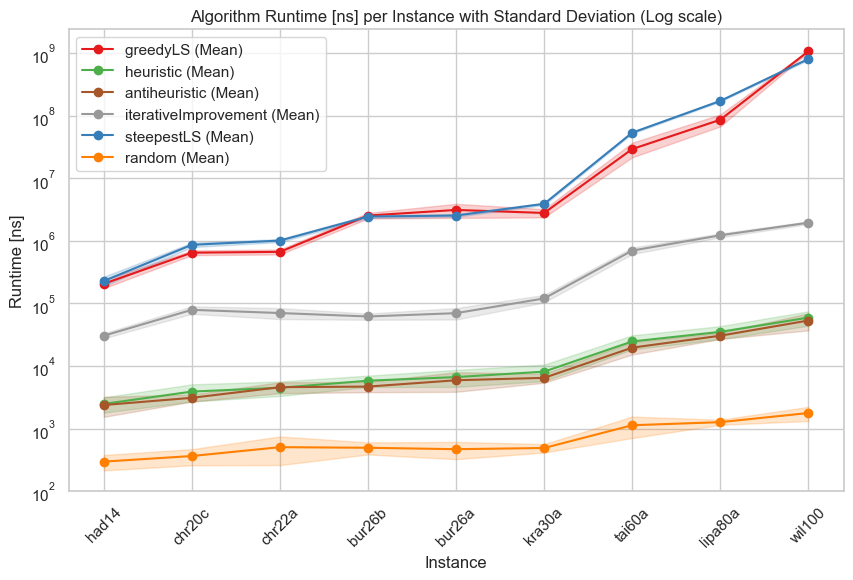

In [12]:
summary = df_runtime.groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")
plot_algorithms(summary, title="Runtime [ns]", log_scale=True)

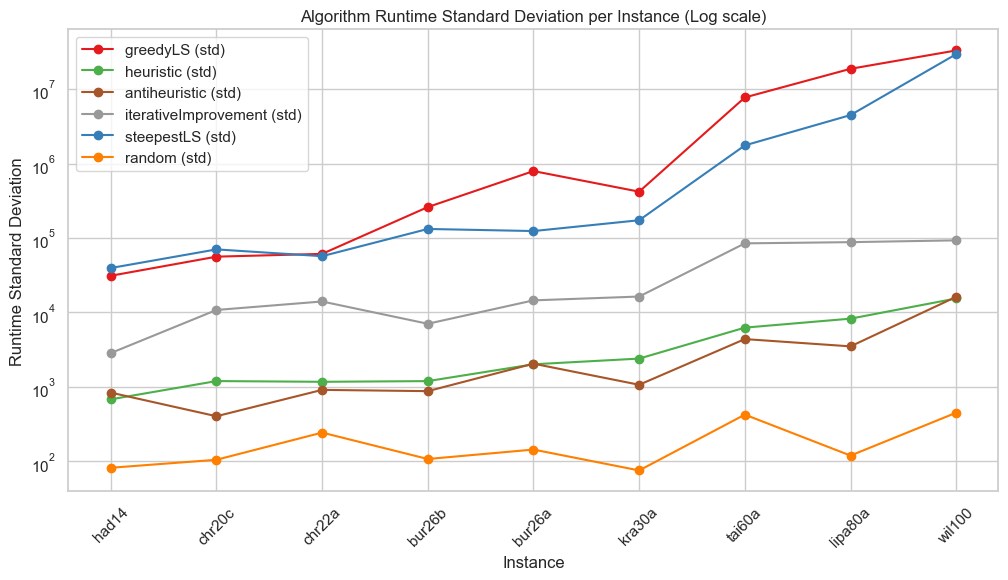

In [13]:
plot_std_line(summary, title="Runtime Standard Deviation", log_scale=True)

In [14]:
# ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
# plot_algorithms(ls_algorithms, title="Runtime [ns]")

In [15]:
# non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS")]
# plot_algorithms(non_ls_algorithms, title="Runtime [ns]")

## Quality

In [16]:
df_performance["Solution_Quality"] = (df_performance["Score"] - df_performance["Optimal_Score"]) / df_performance["Optimal_Score"] * 100

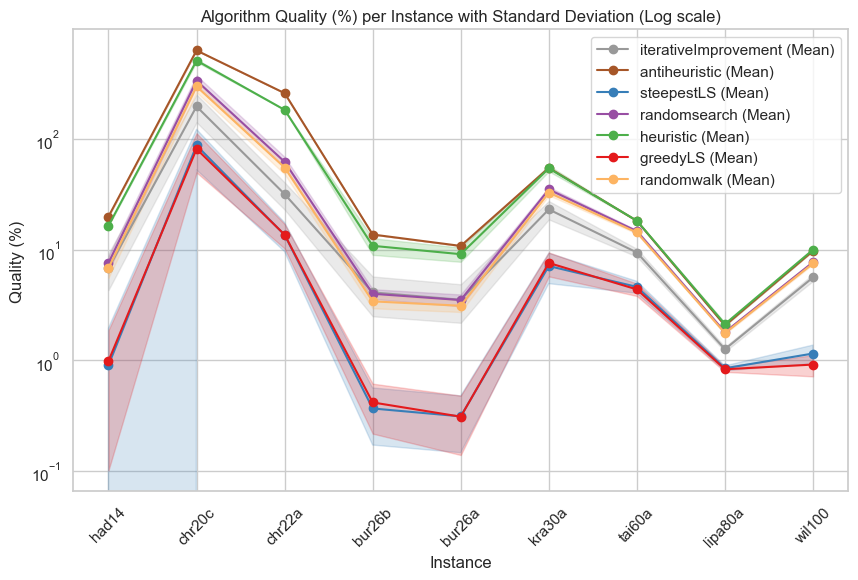

In [17]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Solution_Quality"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
# summary = summary[summary.Instance != "chr22a"]
summary = summary.sort_values("Instance")
plot_algorithms(summary, title="Quality (%)", log_scale=True)

In [18]:
df_performance[df_performance["Algorithm"] == "steepestLS"].groupby(["Instance", "Optimal_Score"])["Score"].agg(min)

C:\Users\Bartek\AppData\Local\Temp\ipykernel_36192\2341288649.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_performance[df_performance["Algorithm"] == "steepestLS"].groupby(["Instance", "Optimal_Score"])["Score"].agg(min)


Instance  Optimal_Score
bur26a    5426670          5427110
bur26b    3817852          3817852
chr20c    14142              15770
chr22a    6156                6438
had14     2724                2724
kra30a    88900              90620
lipa80a   253195            255033
tai60a    7208572          7457456
wil100    273038            274816
Name: Score, dtype: int64

Note: steepest achieves global optimum for had14

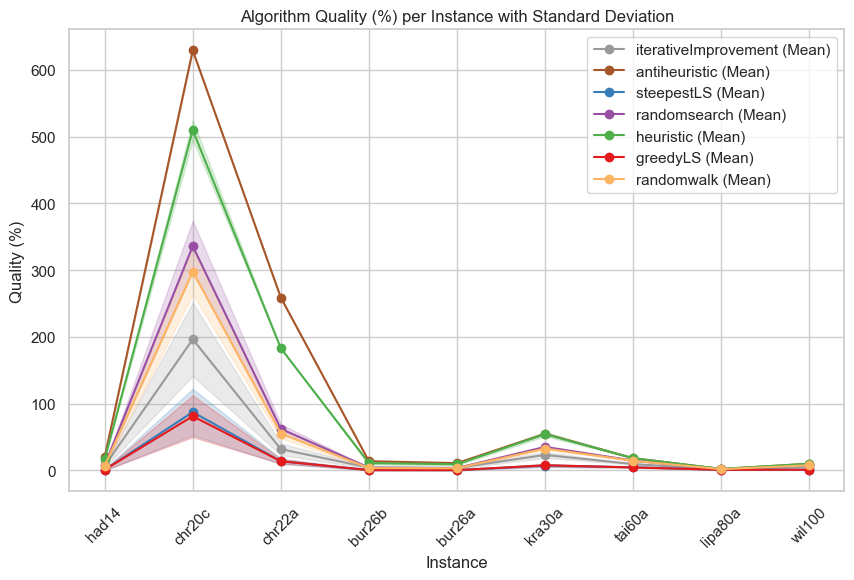

In [19]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Solution_Quality"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
# summary = summary[~summary.Instance.str.startswith("chr")]
summary = summary.sort_values("Instance")
plot_algorithms(summary, title="Quality (%)", log_scale=False)

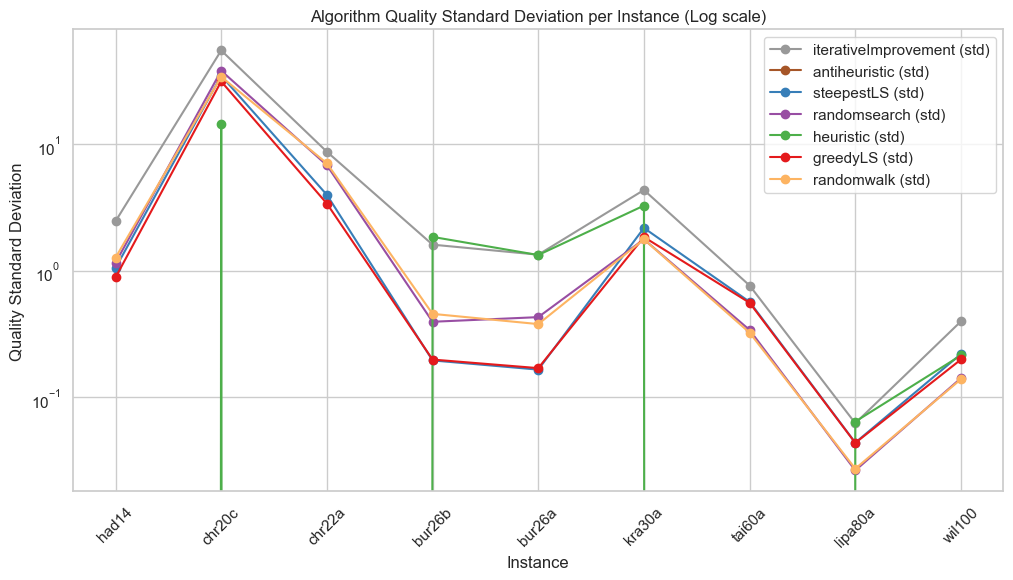

In [20]:
plot_std_line(summary, title="Quality Standard Deviation", log_scale=True)

## Efficiency

In [21]:
df_runtime_summary = df_runtime.groupby(["Algorithm", "Instance"]).agg(
    mean_runtime=("Runtime", "mean"),
    std_runtime=("Runtime", "std")
).reset_index()

df_combined = df_performance.merge(df_runtime_summary, on=["Algorithm", "Instance"], how="left")

df_combined["Solution_Quality"] = (df_combined["Score"] - df_combined["Optimal_Score"]) / df_combined["Optimal_Score"] * 100

df_combined.loc[df_combined["Algorithm"].isin(["randomwalk", "randomsearch"]), "mean_runtime"] = df_combined["Instance"].map(RANDOMRUNTIMES)
df_combined.loc[df_combined["Algorithm"].isin(["randomwalk", "randomsearch"]), "std_runtime"] = 0.0

df_combined.head()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution,Solution_Quality,mean_runtime,std_runtime
0,heuristic,wil100,0,300960,1,1,1,98 73 58 17 43 39 49 82 97 29 76 57 35 96 99 9...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,10.226415,59366.7,15414.268261
1,heuristic,wil100,0,299788,1,1,1,1 73 22 17 43 39 5 82 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,9.797171,59366.7,15414.268261
2,heuristic,wil100,0,300900,1,1,1,98 73 58 82 43 39 49 17 97 29 76 57 35 96 99 9...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,10.204440,59366.7,15414.268261
3,heuristic,wil100,0,301644,1,1,1,98 73 58 17 43 39 5 82 97 29 76 57 35 96 99 94...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,10.476930,59366.7,15414.268261
4,heuristic,wil100,0,299436,1,1,1,1 73 22 82 43 39 5 17 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,9.668251,59366.7,15414.268261


In [22]:
def plot_efficiency(summary, legend=True, show_instances=True, 
                    title="Algorithm Performance: Runtime vs. Solution Quality",
                    log_scale_x=True, log_scale_y=True):
    # Set up plot
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="whitegrid")

    # Get unique algorithms and instances
    algorithms = summary["Algorithm"].unique()
    instances = summary["Instance"].unique()
    colors = sns.color_palette("tab10", len(algorithms))
    markers = ["o", "s", "D", "v", "^"]  # Different markers for instances
    
    # Dictionary to track if an algorithm has been added to the legend
    algorithm_legend = {}

    # Plot each algorithm-instance pair
    for i, algorithm in enumerate(algorithms):
        for j, instance in enumerate(instances):
            subset = summary[(summary["Algorithm"] == algorithm) & (summary["Instance"] == instance)]
            if not subset.empty:
                if show_instances:
                    label = label=f"{algorithm} - {instance}"
                else:
                    label = algorithm if algorithm not in algorithm_legend else "_nolegend_"
                plt.errorbar(
                    subset["mean_quality"], subset["mean_runtime"],
                    xerr=subset["std_quality"], yerr=subset["std_runtime"],
                    fmt=markers[j % len(markers)], color=algorithm_colors[algorithm], label=label,
                    capsize=3, linestyle="none"
                )
                algorithm_legend[algorithm] = True

    # Labels and legend
    plt.ylabel("Runtime [ns] (Mean ± Std)")
    plt.xlabel("Solution Quality (Mean ± Std)")
    
    if log_scale_x:
        plt.xscale("log")
    
    if log_scale_y:
        plt.yscale("log")
    
    full_title = f"{title}"
    
    if log_scale_x and log_scale_y:
        full_title += " (Log scale x y)"
    elif log_scale_x:
        full_title += " (Log scale x)"
    elif log_scale_y:
        full_title += " (Log scale y)"

    plt.title(full_title)
    if legend:
        plt.legend(loc="upper right", fontsize=9, ncol=5)
    plt.show()


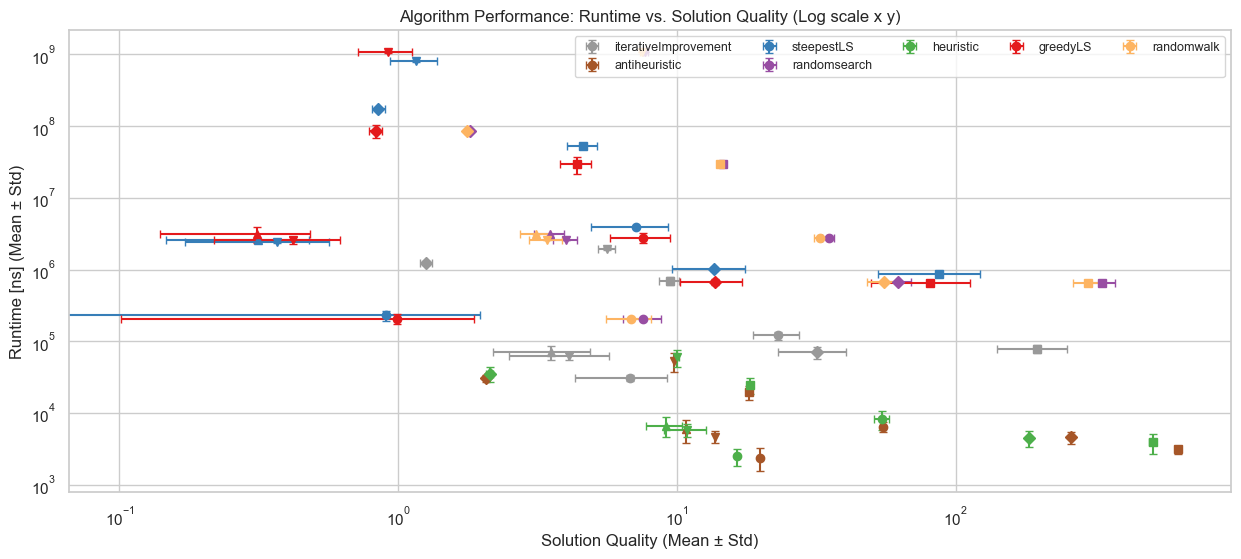

In [23]:
summary = df_combined.groupby(["Algorithm", "Instance"]).agg(
    mean_runtime=("mean_runtime", "mean"),
    std_runtime=("std_runtime", "mean"),
    mean_quality=("Solution_Quality", "mean"),
    std_quality=("Solution_Quality", "std")
).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS|random")]
ls_algorithms = summary[summary["Algorithm"].str.contains("LS|random")]

plot_efficiency(summary, show_instances=False, log_scale_x=True, log_scale_y=True)
# plot_efficiency(non_ls_algorithms, show_instances=False, log_scale_x=True, log_scale_y=True)
# plot_efficiency(ls_algorithms, show_instances=False, log_scale_x=True, log_scale_y=True)

## Number of Moves/Evaluations/Best Solution Updates

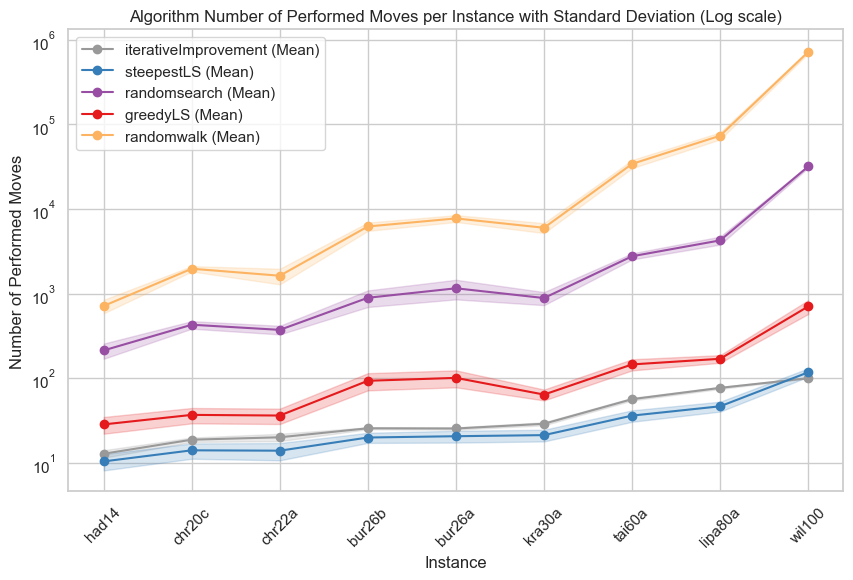

In [24]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Performed_Moves"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms(summary, title="Number of Performed Moves", log_scale=True)

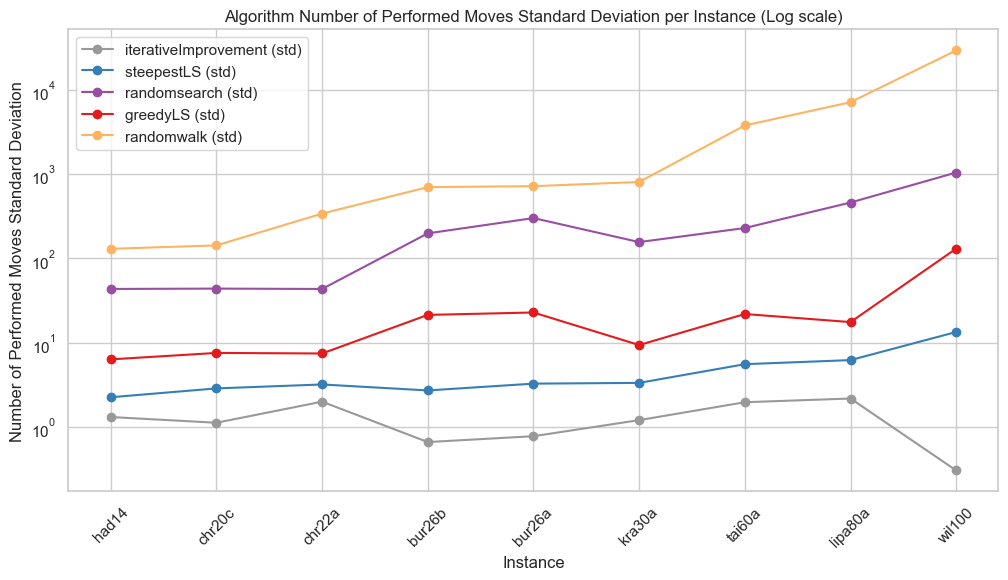

In [25]:
plot_std_line(summary, title="Number of Performed Moves Standard Deviation", log_scale=True)

In [26]:
# ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
# plot_algorithms(ls_algorithms, title="Number of Performed Moves")

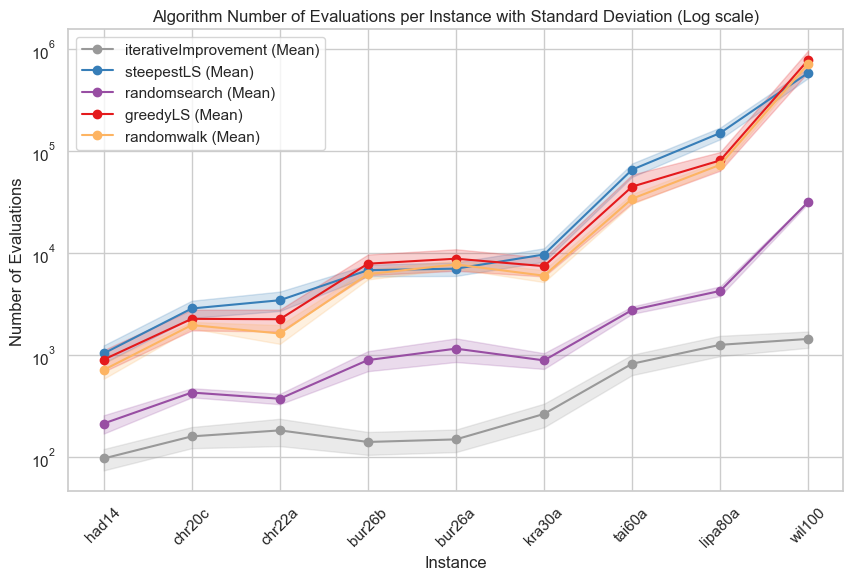

In [27]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Evaluations"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms(summary, title="Number of Evaluations", log_scale=True)

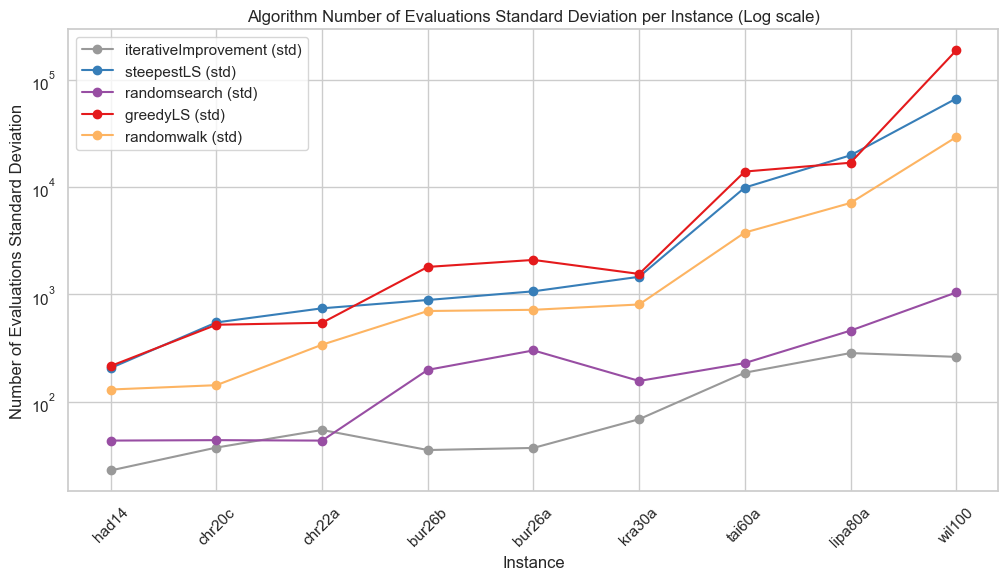

In [28]:
plot_std_line(summary, title="Number of Evaluations Standard Deviation", log_scale=True)

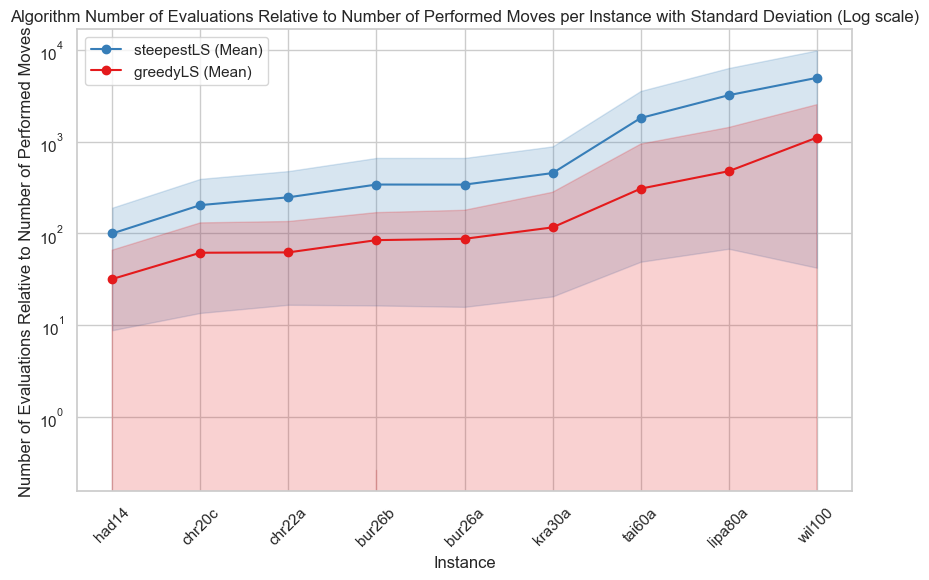

In [29]:
summary = df_performance.groupby(["Algorithm", "Instance"])[["Number_of_Evaluations", "Number_of_Performed_Moves"]].agg(["mean", "std"]).reset_index()
summary.columns = ['_'.join(col).strip('_') for col in summary.columns]

summary["Relative_Evaluations_mean"] = summary["Number_of_Evaluations_mean"] / summary["Number_of_Performed_Moves_mean"]
summary["Relative_Evaluations_std"] = summary["Number_of_Evaluations_std"] / summary["Number_of_Performed_Moves_std"]

summary = summary[["Algorithm", "Instance", "Relative_Evaluations_mean", "Relative_Evaluations_std"]]
summary = summary.rename(columns={"Relative_Evaluations_mean": "mean", "Relative_Evaluations_std": "std"})

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[summary["Algorithm"].str.contains("LS")]

# TODO weird std?
plot_algorithms(summary, "Number of Evaluations Relative to Number of Performed Moves", log_scale=True)

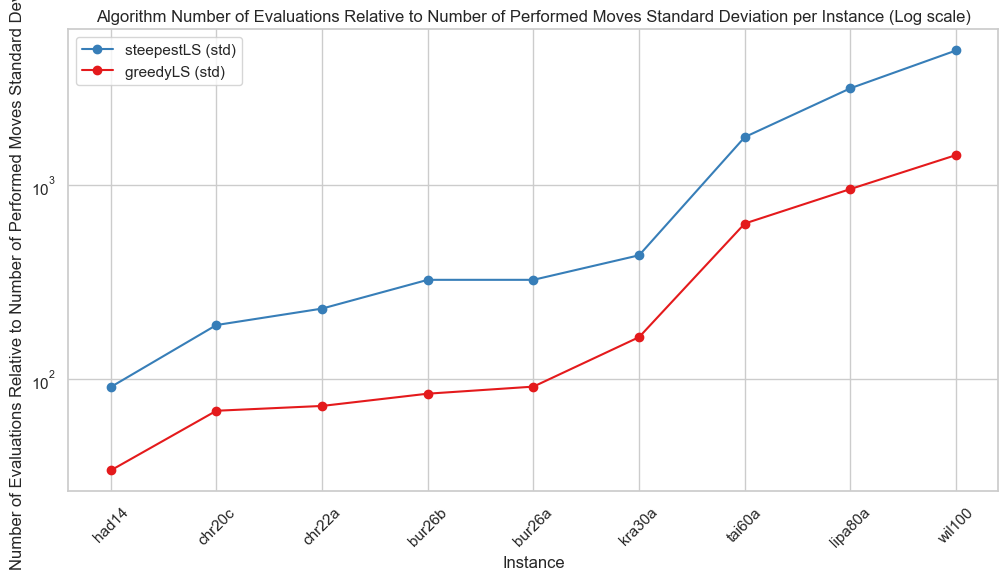

In [30]:
plot_std_line(summary, title="Number of Evaluations Relative to Number of Performed Moves Standard Deviation", log_scale=True)

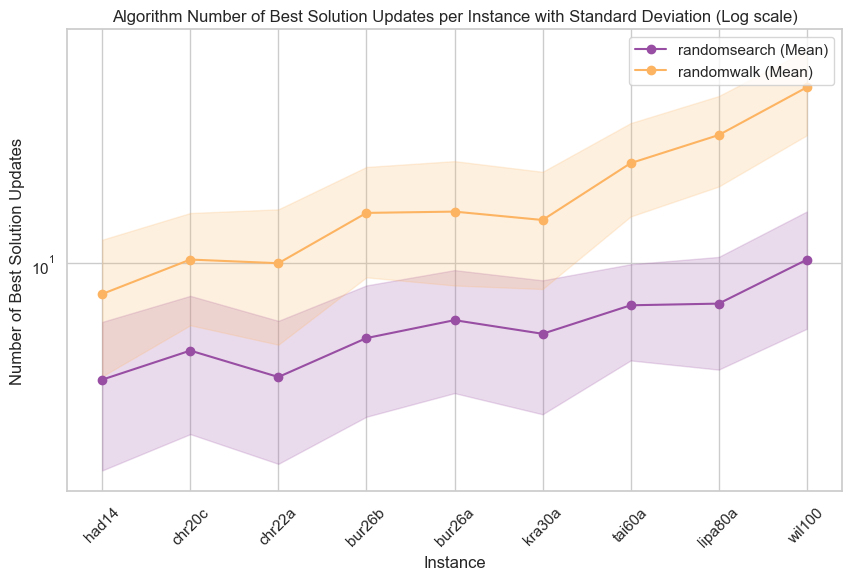

In [31]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Best_Solution_Updates"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[summary["Algorithm"].str.contains("random")]
plot_algorithms(summary, title="Number of Best Solution Updates", log_scale=True)

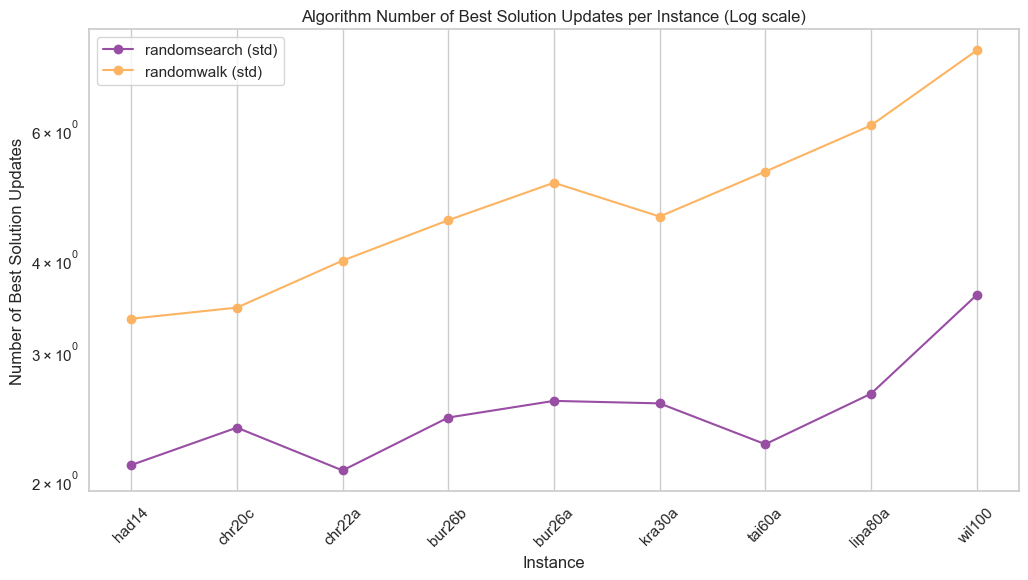

In [32]:
plot_std_line(summary, title="Number of Best Solution Updates", log_scale=True)

## Initial Solution Comparison

In [33]:
def plot_ls_algorithms_comparison(df, algorithm=""):
    # Set up plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Scatter plot with different colors per algorithm
    sns.scatterplot(
        data=df,
        x="Initial_Score",
        y="Score",
        hue="Instance",
        palette="tab10",
        alpha=0.6  # Slight transparency for better visibility
    )

    # Labels and title
    plt.yscale("log") 
    plt.xscale("log") 

    # plt.xlabel("Initial Solution Score")
    # plt.ylabel("Final Solution Score")
    plt.title(f"Comparison of LS Algorithms: Initial vs. Final Solution Score {algorithm}")
    plt.legend(title="Instance", loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside

    # Show plot
    plt.show()

def plot_ls_algorithms_comparison_all(df, algorithm=""):
    # Set up plot
    sns.set_theme(style="whitegrid")
    
    g = sns.FacetGrid(
        df, col="Instance", hue="Instance", palette="tab10", col_wrap=3, sharex=False, sharey=False
    )

    g.map_dataframe(
        sns.scatterplot, x="Initial_Score", y="Score",
        s=10,
        alpha=0.5,
        edgecolor='none'
    )

    # Compute correlation and set subplot titles
    def set_titles(**kwargs):
        ax = plt.gca()
        instance = kwargs.get('label', '')
        subset = df[df['Instance'] == instance]
        correlation = subset["Initial_Score"].corr(subset["Score"]) if not subset.empty else np.nan
        ax.set_title(f"{instance} Cor = {correlation:.2f}")
    
    g.map_dataframe(set_titles)
    
    g.figure.suptitle(f"Comparison of LS Algorithms: Initial vs. Final Solution Score {algorithm}", fontsize=16)
    g.figure.subplots_adjust(top=0.9)
    
    plt.show()

In [34]:
with open(performance_file_300, 'r') as file:
    data = file.read()

df_performance_300 = parse_performance_data(data)
df_performance_300.Algorithm = df_performance_300.Algorithm.apply(lambda x: x[1:] if (x.endswith("LS") or x.endswith("Improvement")) else x)

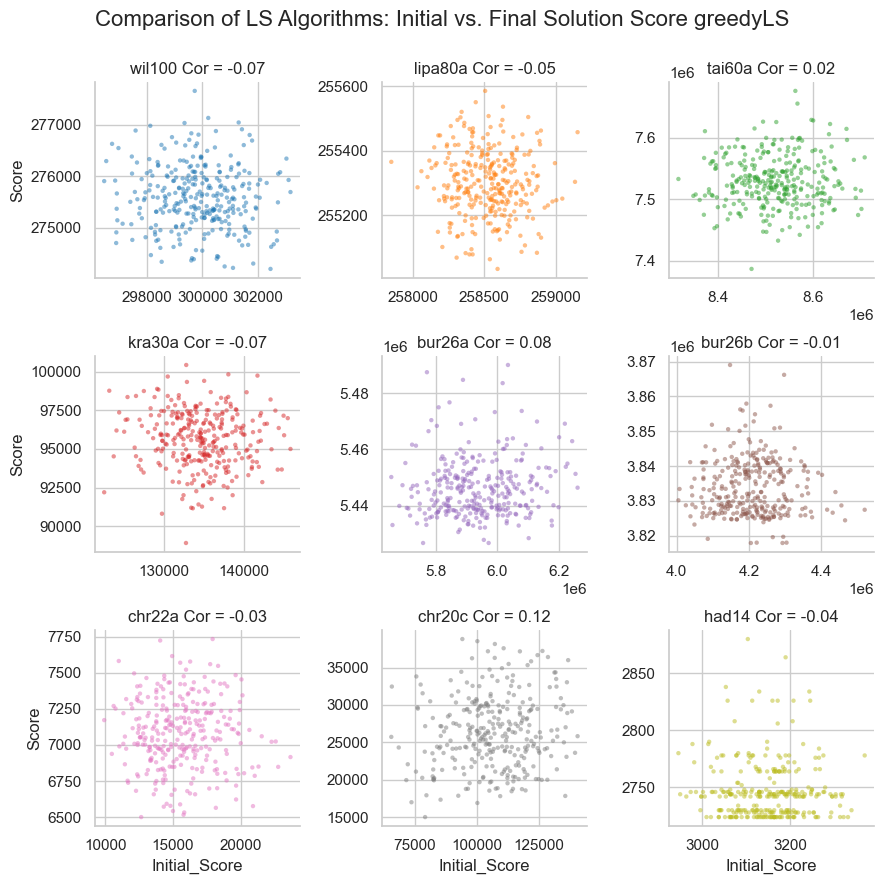

In [35]:
plot_ls_algorithms_comparison_all(df_performance_300[df_performance_300["Algorithm"].str.contains("greedyLS", case=False, na=False)], algorithm="greedyLS")

In [36]:
# TODO log scale?
# plot_ls_algorithms_comparison(df_performance[df_performance["Algorithm"].str.contains("greedyLS", case=False, na=False)], algorithm="greedyLS")

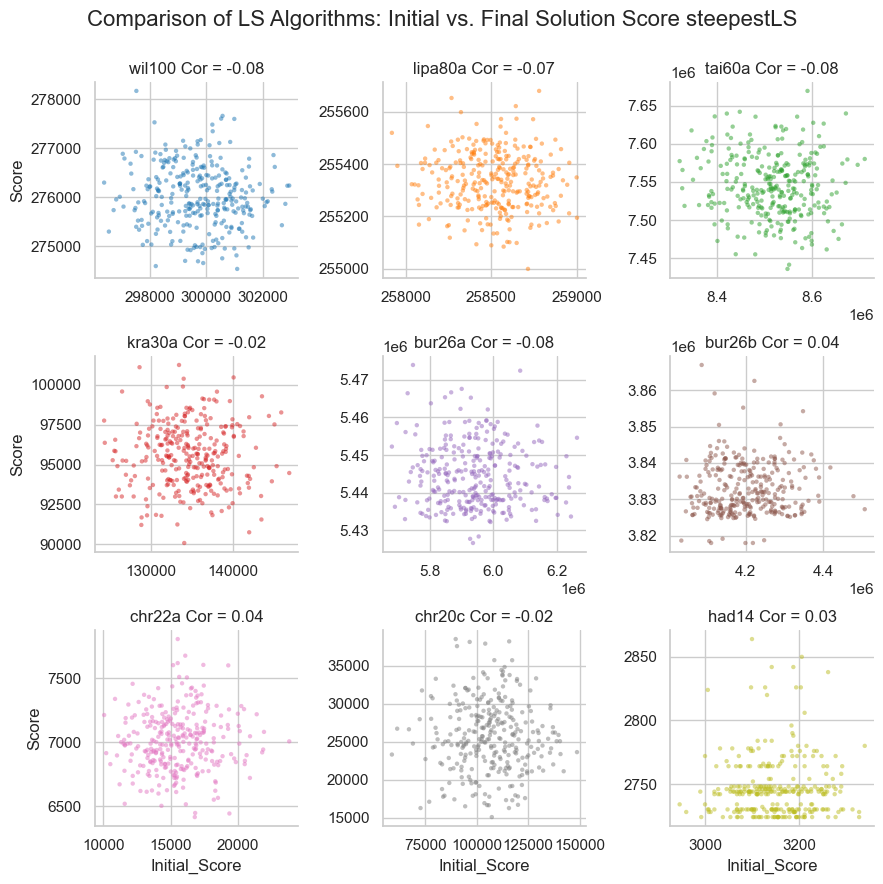

In [37]:
plot_ls_algorithms_comparison_all(df_performance_300[df_performance_300["Algorithm"].str.contains("steepestLS", case=False, na=False)], algorithm="steepestLS")

In [38]:
# plot_ls_algorithms_comparison(df_performance[df_performance["Algorithm"].str.contains("steepestLS", case=False, na=False)], "steepestLS")

## Number of Restarts Influence

Done for: ["tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "chr20c", "had14"] <br>
Because of shorter runtime :)

In [39]:
dfs_msls = []
for n_restarts in num_restarts:
    restarts_file = restarts_files_path + f"{n_restarts}_msls_performance_results.txt"
    with open(restarts_file, 'r') as file:
        data = file.read()

    df_perf = parse_performance_data(data)
    df_perf.Algorithm = df_perf.Algorithm.apply(lambda x: x[1:] if (x.endswith("LS") or x.endswith("Improvement")) else x)
    df_perf = df_perf[df_perf.Algorithm != "iterativeImprovement"]
    df_perf = df_perf[["Algorithm", "Instance", "Initial_Score", "Score", "Solution"]]
    dfs_msls.append((n_restarts, df_perf))

In [53]:
def plot_algorithm_performance(restart_data):
    sns.set_theme(style="whitegrid")

    # Create combined dataframes for all restarts
    avg_results = []
    best_results = []
    for num_restarts, df in restart_data:
        df = df.copy()
        df["Restarts"] = num_restarts  # Assign restarts column
        avg_scores = df.groupby(["Instance", "Algorithm", "Restarts"], as_index=False)["Score"].mean()
        best_scores = df.groupby(["Instance", "Algorithm", "Restarts"], as_index=False)["Score"].min()
        avg_results.append(avg_scores)
        best_results.append(best_scores)

    # Merge into final DataFrames
    avg_df = pd.concat(avg_results, ignore_index=True)
    best_df = pd.concat(best_results, ignore_index=True)

    # Filter only instances in the given order
    avg_df = avg_df[avg_df["Instance"].isin(instance_names_ordered)]
    best_df = best_df[best_df["Instance"].isin(instance_names_ordered)]

    # Sort instances in the given order
    avg_df["Instance"] = pd.Categorical(avg_df["Instance"], categories=instance_names_ordered, ordered=True)
    best_df["Instance"] = pd.Categorical(best_df["Instance"], categories=instance_names_ordered, ordered=True)
    
    avg_df = avg_df.sort_values("Instance")
    best_df = best_df.sort_values("Instance")

    # Define function for plotting
    def plot_scores(df, title, score_type):
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=df,
            x="Instance",
            y="Score",
            hue="Restarts",  # Each restart count gets a separate line
            palette="tab10",  # Use default Seaborn colors
            marker="o"
        )

        plt.xticks(rotation=45, ha="right")
        plt.title(title)
        plt.xlabel("Instance")
        plt.ylabel(f"{score_type} Solution Score")
        plt.yscale("log")
        plt.legend(title="Restarts")
        plt.grid(axis='y', linestyle="--", alpha=0.7)
        plt.show()

    # Plot for GreedyLS - Average Score
    plot_scores(avg_df[avg_df["Algorithm"] == "greedyLS"], "GreedyLS - Average Solution Score", "Average")

    # Plot for GreedyLS - Best Score
    plot_scores(best_df[best_df["Algorithm"] == "greedyLS"], "GreedyLS - Best Solution Score", "Best")

    # Plot for SteepestLS - Average Score
    plot_scores(avg_df[avg_df["Algorithm"] == "steepestLS"], "SteepestLS - Average Solution Score", "Average")

    # Plot for SteepestLS - Best Score
    plot_scores(best_df[best_df["Algorithm"] == "steepestLS"], "SteepestLS - Best Solution Score", "Best")


## TODO verify - check raw means in dfs

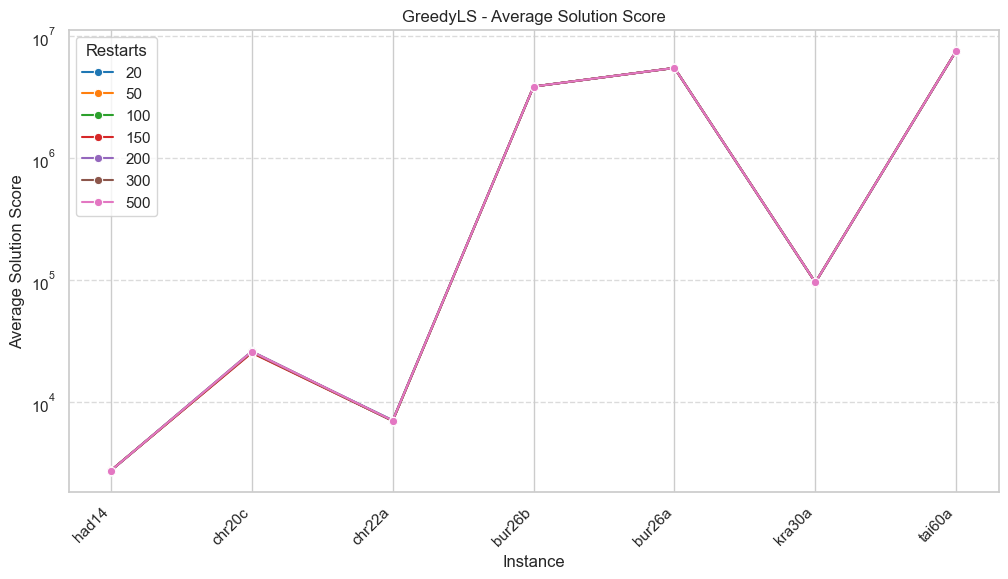

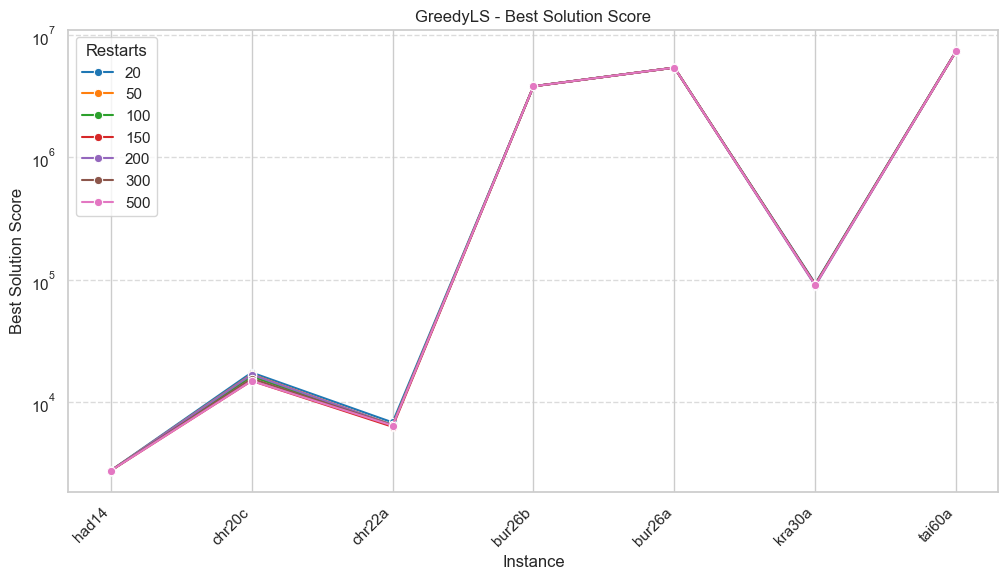

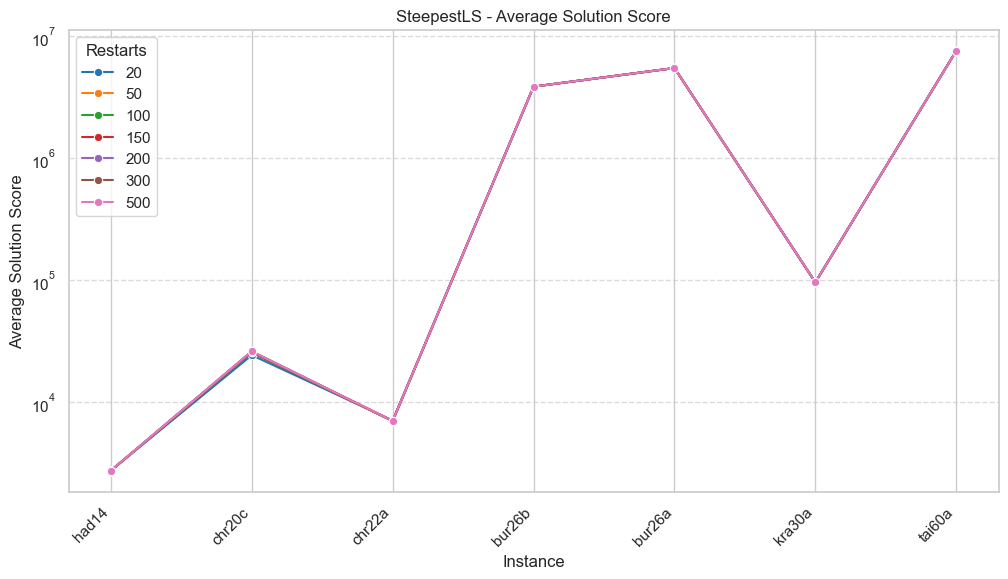

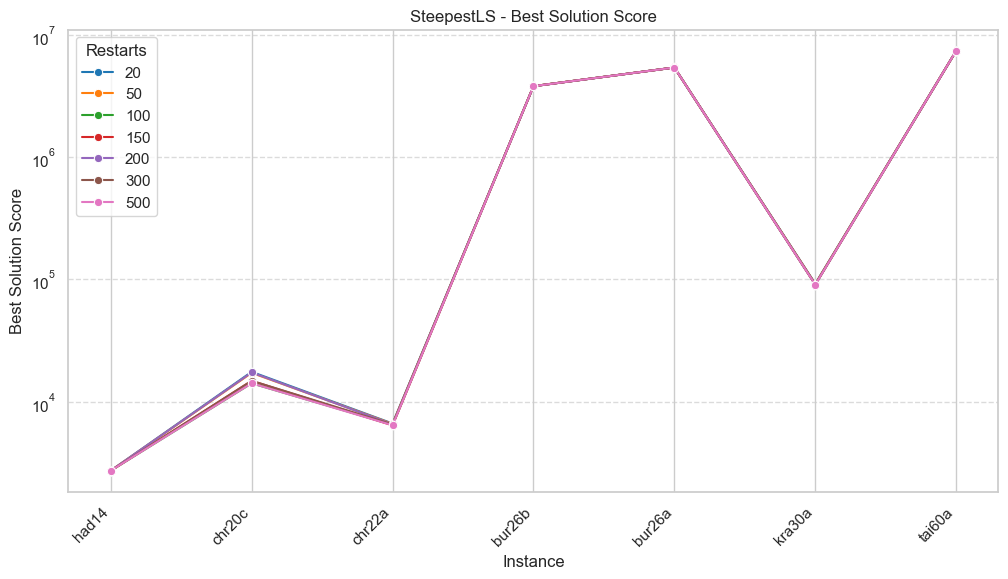

In [54]:
plot_algorithm_performance(dfs_msls)

## Similarity of Locally Optimal Solutions

In [42]:
df_performance_300 = parse_performance_data(data)
df_performance_300.Algorithm = df_performance_300.Algorithm.apply(lambda x: x[1:] if (x.endswith("LS") or x.endswith("Improvement")) else x)

df_performance_300.Solution = df_performance_300.Solution.apply(lambda x: list(map(int, x.split(" ")[:-1])))
df_performance_300.Optimal_Solution = df_performance_300.Optimal_Solution.apply(lambda x: list(map(int, x.split(" ")[:-1])))
df_performance_300.tail()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution
10495,iterativeImprovement,had14,3238,2992,87,13,0,"[10, 4, 0, 13, 8, 5, 11, 12, 3, 6, 1, 2, 9, 7]",2724,"[8, 13, 10, 5, 12, 11, 2, 14, 3, 6, 7, 1, 9, 4]"
10496,iterativeImprovement,had14,3160,2848,92,13,0,"[0, 8, 4, 11, 6, 2, 5, 10, 3, 1, 13, 9, 12, 7]",2724,"[8, 13, 10, 5, 12, 11, 2, 14, 3, 6, 7, 1, 9, 4]"
10497,iterativeImprovement,had14,2940,2784,156,9,0,"[3, 8, 6, 5, 13, 10, 7, 4, 0, 11, 9, 1, 12, 2]",2724,"[8, 13, 10, 5, 12, 11, 2, 14, 3, 6, 7, 1, 9, 4]"
10498,iterativeImprovement,had14,3268,3062,93,14,0,"[12, 4, 13, 3, 5, 10, 0, 8, 7, 11, 9, 6, 1, 2]",2724,"[8, 13, 10, 5, 12, 11, 2, 14, 3, 6, 7, 1, 9, 4]"
10499,iterativeImprovement,had14,3022,2828,108,12,0,"[8, 13, 0, 5, 6, 11, 1, 10, 3, 9, 2, 4, 12, 7]",2724,"[8, 13, 10, 5, 12, 11, 2, 14, 3, 6, 7, 1, 9, 4]"


In [43]:
def compute_similarity(solution1, solution2):
    return sum(1 for a, b in zip(solution1, solution2) if a == b)/len(solution1)*100

def plot_solution_quality_vs_similarity(df, instances=["chr15a", "tai60c"]):
    sns.set_theme(style="whitegrid")
    
    for instance in instances:
        subset = df[df["Instance"] == instance]
        
        plot_data = []
        
        # print(subset)
        for _, row in subset.iterrows():
            similarity = compute_similarity(row["Optimal_Solution"], row["Solution"])
            plot_data.append({
                "Algorithm": row["Algorithm"],
                "Quality": (row["Score"] - row["Optimal_Score"]) / row["Optimal_Score"] * 100,
                "Similarity": similarity
            })
        
        plot_df = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=plot_df, x="Quality", y="Similarity", hue="Algorithm", palette=algorithm_colors, alpha=0.7)
        plt.title(f"Solution Quality vs. Similarity to Optimal Solution for {instance}")
        plt.xlabel("Solution Quality")
        plt.ylabel("Similarity to Optimal Solution (%)")
        plt.legend(title="Algorithm")
        plt.show()


# Distance TODO verify (check other instances)

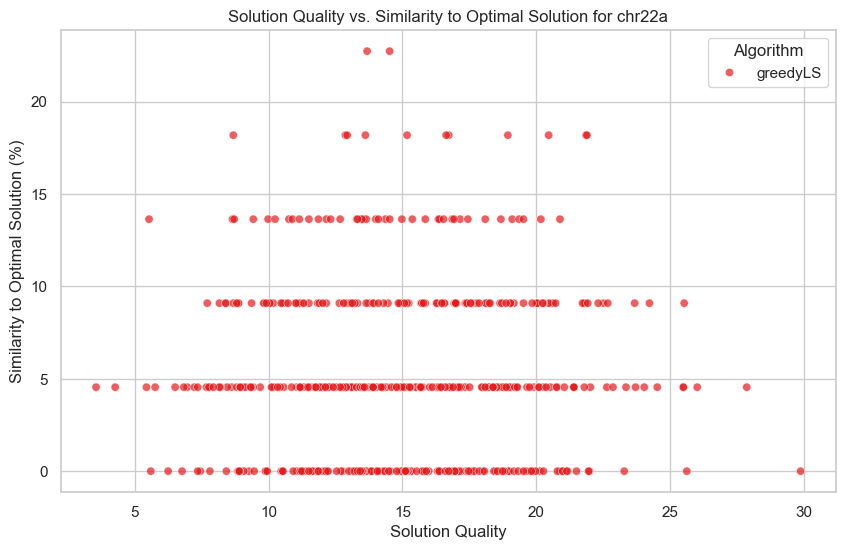

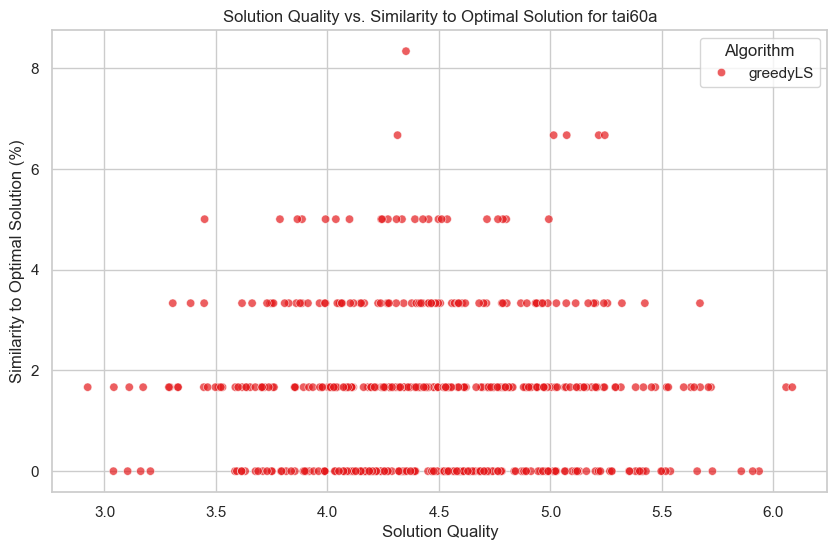

In [44]:
plot_solution_quality_vs_similarity(df_performance_300[df_performance_300.Algorithm == "greedyLS"], selected_instances)

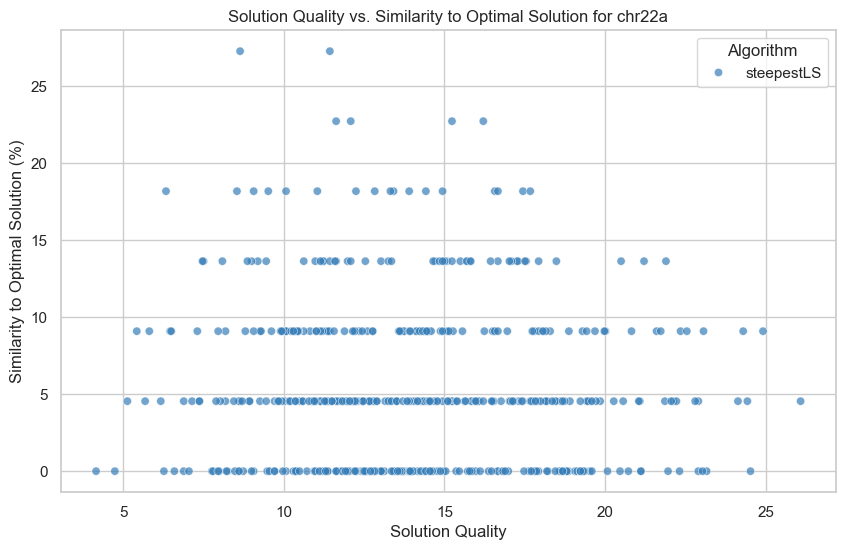

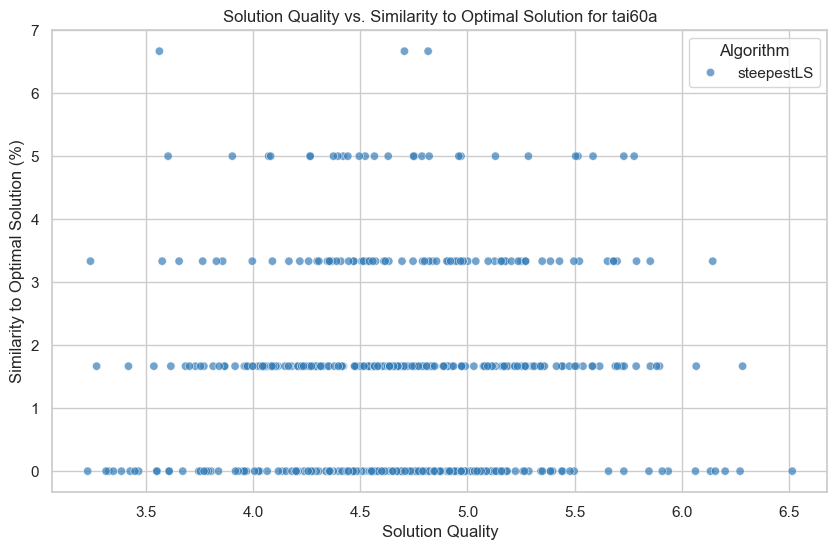

In [45]:
plot_solution_quality_vs_similarity(df_performance_300[df_performance_300.Algorithm == "steepestLS"], selected_instances)